In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

# Data Story

### Data Source
Portion of full dataset that has been cleaned and manipulated to include location (in latitude/longitude and ecef-Regtangular Cartesian), street, time, distance to traffic sensor (in meters), and traffic count (at sensor closest to crash location)

In [2]:
crash_location = pd.read_pickle('crash_location.pkl')
crash_location.tail()

,DEC_LAT,DEC_LONG,STREET_NAME,datetime,ecef,sensor_distance,traffic
141982,40.4541,-79.8908,KELLY ST,2016-10-07 01:02:00,"(853075.781582, -4784690.02494, 4116482.84218)",681.753346,37.0
141983,40.4578,-79.7397,OLD FRANKSTOWN RD,2016-12-07 11:59:00,"(865643.46358, -4782161.33507, 4116795.46809)",597.310206,311.0
141984,40.6674,-79.9790,VALENCIA RD,2016-12-06 05:14:00,"(843029.244793, -4770830.63491, 4134477.47916)",10.371036,75.0
141985,40.4430,-79.8390,PENN LINCOLN PY,2016-12-07 01:17:00,"(857542.248496, -4784703.93343, 4115544.86237)",117.253831,283.0
141986,40.4435,-80.0068,TENTH ST BY,2016-11-03 21:26:00,"(843519.558023, -4787159.39219, 4115587.117)",27.906064,163.0


If we visualize crash frequency over each hour, we see a peak around 17 corresponding to 5pm on a 12hr scale. It is not surprising the most crashes occur during rush hour because there is higher traffic and thus more opportunities for crashes.

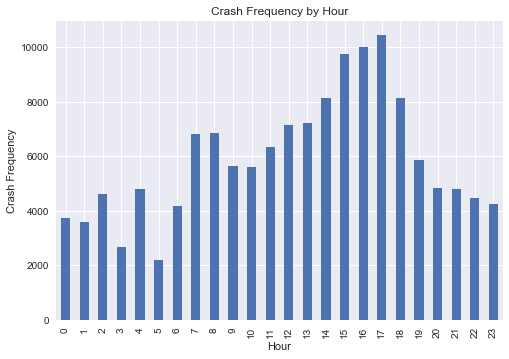

In [3]:
crash_location.datetime.dt.hour.value_counts().sort_index().plot(kind = 'bar')
plt.title('Crash Frequency by Hour')
plt.xlabel('Hour')
plt.ylabel('Crash Frequency')

In order to determine which hours have the highest risk of crashes, we can divide the total number of crashes each hour by the total hourly traffic to get crash frequency/1 vehicle of traffic or the risk for an individual car of experiencing a crash each hour.

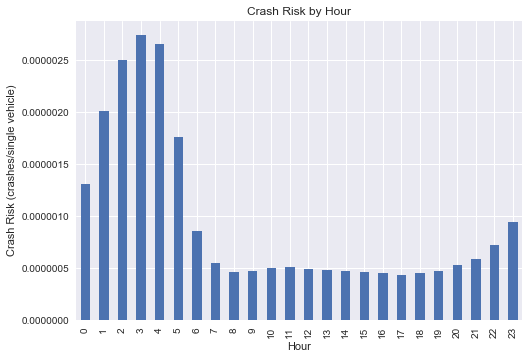

In [4]:
a = crash_location.datetime.dt.hour.value_counts().sort_index()
b = crash_location.groupby(crash_location.datetime.dt.hour).sum().traffic
# Multiplying by 4728, total days in recorded crash period to divide by total hourly traffic, rather than average hourly traffic
(a/(b * 4728)).plot(kind = 'bar')
plt.title('Crash Risk by Hour')
plt.xlabel('Hour')
plt.ylabel('Crash Risk (crashes/single vehicle)')

Although the crash frequency is highest during the afternoon rush hour, crash risk spikes over night with 2-4am being the most risky hours.

Another way to study the relationship between crash risk/crash frequency and traffic is to use scatter plots

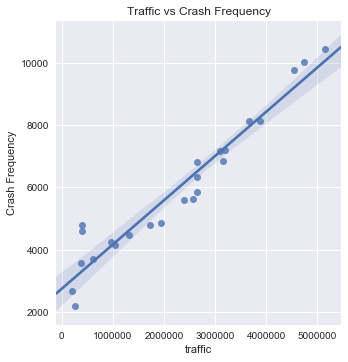

In [5]:
hourly_traffic_crashes = pd.concat([a,b], axis = 1)
sns.lmplot('traffic','datetime', data = hourly_traffic_crashes)
plt.title('Traffic vs Crash Frequency')
plt.ylabel('Crash Frequency')

The strong positive correlation between traffic and crash frequency supports the observation that high traffic periods correspond with higher crash frequencies.

(0, 1e-06)

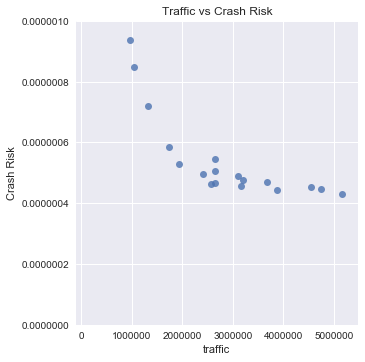

In [6]:
hourly_traffic_crashes['normalized'] = hourly_traffic_crashes.datetime/(hourly_traffic_crashes.traffic * 4728)
sns.lmplot('traffic','normalized', data = hourly_traffic_crashes, fit_reg = False)
plt.title('Traffic vs Crash Risk')
plt.ylabel('Crash Risk')
plt.ylim([0, .000001])

The relationship between crash risk and traffic reveals that low hourly traffic corresponds with a higher crash risk. It is important to realize that these low traffic periods occur during the night hours, so this plot serves to illustrate the relationship between low-traffic (night) hours and crash risk.

Let's look at the most dangerous roads in the Pittsburgh area.

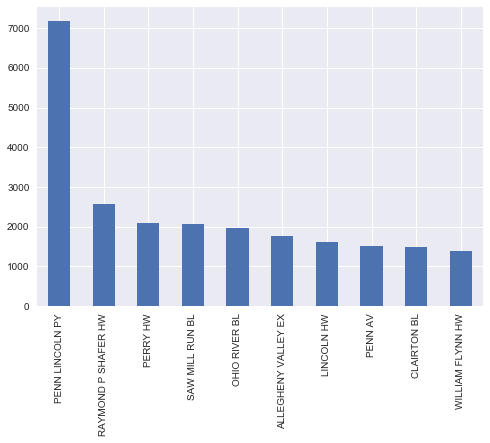

In [7]:
crash_location.STREET_NAME.value_counts().head(10).plot(kind = 'bar')

The highest crash frequency roads in the Pittsburgh area appear to all be highways! This is unsurprising given the relationship between traffic and crash frequency we have already demonstrated. If we look at crash risk for each road, how do our results change?

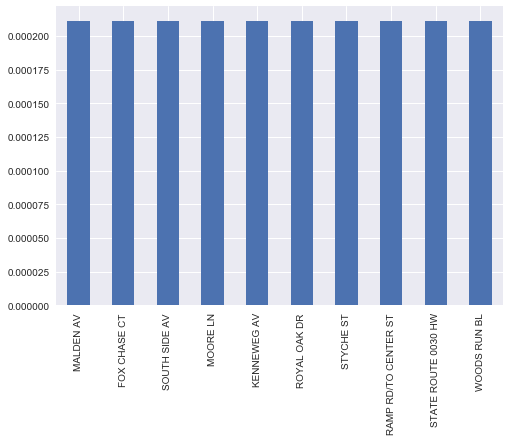

In [8]:
street_traffic = crash_location.groupby('STREET_NAME').sum().traffic
street_crashf = crash_location.STREET_NAME.value_counts().sort_index()
(street_crashf/(street_traffic * 4728)).sort_values(ascending = False).head(10).plot(kind = 'bar')

The top 10 "riskiest" roads have a uniform risk factor of .0002, or 1 crash/500 vehicles of traffic. Looking at the individual roads may reveal the reason for the consistency in risk factor.

In [9]:
crash_location[(crash_location.STREET_NAME == 'MALDEN AV') | (crash_location.STREET_NAME == 'FOX CHASE CT') |
              (crash_location.STREET_NAME == 'SOUTH SIDE AV')]

,DEC_LAT,DEC_LONG,STREET_NAME,datetime,ecef,sensor_distance,traffic
95501,40.3241,-80.120201,FOX CHASE CT,2013-04-03 17:27:00,"(835516.97071, -4797282.28676, 4105487.9388)",806.824070,1.0
137399,40.4695,-79.999300,SOUTH SIDE AV,2016-08-04 03:02:00,"(843820.858169, -4785204.02657, 4117783.92993)",525.218297,1.0
140461,40.4746,-80.033200,MALDEN AV,2016-08-01 02:30:00,"(840925.844082, -4785340.40993, 4118214.74465)",173.727799,1.0


These roads are ranked as riskiest because there is a single crash on the road and single vehicle average hourly traffic because these crashes occured at night and are in residential areas. In order to get a more useful ranking of crash risk, let's only consider roads that have a minimum traffic of 50 cars during at least one crash and more than one crash.

In [10]:
# In order to determine which roads to consider set new column for max traffic for any road, this must be greater than 50
maxt_di = crash_location.groupby(crash_location.STREET_NAME).max().traffic
maxt_di.to_dict()
crash_location['max_traffic'] = crash_location.STREET_NAME.map(maxt_di)
crash_location.tail()

,DEC_LAT,DEC_LONG,STREET_NAME,datetime,ecef,sensor_distance,traffic,max_traffic
141982,40.4541,-79.8908,KELLY ST,2016-10-07 01:02:00,"(853075.781582, -4784690.02494, 4116482.84218)",681.753346,37.0,957.000000
141983,40.4578,-79.7397,OLD FRANKSTOWN RD,2016-12-07 11:59:00,"(865643.46358, -4782161.33507, 4116795.46809)",597.310206,311.0,880.000000
141984,40.6674,-79.9790,VALENCIA RD,2016-12-06 05:14:00,"(843029.244793, -4770830.63491, 4134477.47916)",10.371036,75.0,331.000000
141985,40.4430,-79.8390,PENN LINCOLN PY,2016-12-07 01:17:00,"(857542.248496, -4784703.93343, 4115544.86237)",117.253831,283.0,996.000000
141986,40.4435,-80.0068,TENTH ST BY,2016-11-03 21:26:00,"(843519.558023, -4787159.39219, 4115587.117)",27.906064,163.0,636.166667


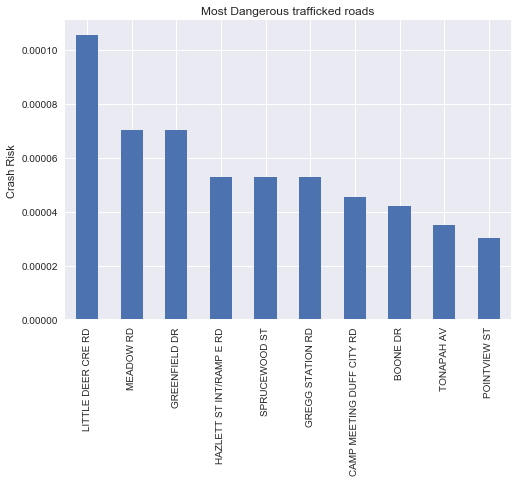

In [11]:
min_traffic = crash_location[(crash_location.max_traffic >= 50) & (crash_location.STREET_NAME.duplicated() == True)]
# duplicated() method returns boolean series indicating which streets are associated with multiple crashes
street_traffic = min_traffic.groupby('STREET_NAME').sum().traffic
street_crashf = min_traffic.STREET_NAME.value_counts().sort_index()
(street_crashf/(street_traffic * 4728)).sort_values(ascending = False).head(10).plot(kind = 'bar')
plt.title('Most Dangerous trafficked roads')
plt.ylabel('Crash Risk')

After restricting the considered roads, we find that Little Deer Cre[ek] road is the most risky road with 1 crash/1000 vehicles. Looking more closely at Little Deer Cre[ek] road reveals the crashes contributing to this risk factor.

In [12]:
crash_location[(crash_location.STREET_NAME == 'LITTLE DEER CRE RD')]

,DEC_LAT,DEC_LONG,STREET_NAME,datetime,ecef,sensor_distance,traffic,max_traffic
19176,40.583199,-79.826302,LITTLE DEER CRE RD,2006-06-06 22:30:00,"(856816.282801, -4774559.28357, 4127380.75979)",379.931888,117.0,117.0
22639,40.596600,-79.829597,LITTLE DEER CRE RD,2006-11-05 03:45:00,"(856370.660308, -4773655.53956, 4128510.82539)",931.862354,2.0,117.0


The high crash risk factor is due to the crash at 3:45am where the low hourly traffic contributes significantly to the crash risk factor. Crash risk is calculated by crashes/total hourly traffic, for Little Deek Creek road the crash at 3:45am makes the crash risk factor 1/(4728 x 2) = .000106 while the crash at 10:30pm (22:30) adds a crash risk factor of 1/(4728 x 117) = .00000181. This demonstrates that crash risk is highly dependent on hourly traffic, a higher hourly traffic at 10:30pm resulted in a crash that did not affect the total crash risk (because of rounding).

The risk factor does a good job when there is a consistent amount of traffic but crashes at low traffic times have disproportionately high influence.

This can be rectified by modifying the contribution of a crash to the risk factor but the risk factor has other issues. Currently, we are considering only frequency of crashes but the true danger of a road is not only the frequency of its crashes but also the crashes severity. We will consider new data including severity, and take a look again at the most dangerous roads after finishing exploration of crash frequency.

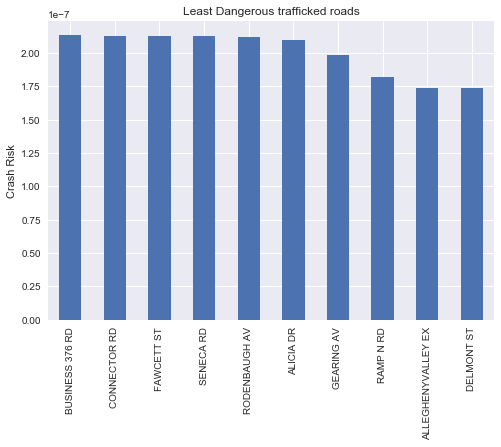

In [13]:
(street_crashf/(street_traffic * 4728)).sort_values(ascending = False).tail(10).plot(kind = 'bar')
plt.title('Least Dangerous trafficked roads')
plt.ylabel('Crash Risk')

The least dangerous roads have higher traffic, and few crashes. It is interesting that highways do not appear on the top 10 least dangerous given the high traffic counts.

In [14]:
crash_location[(crash_location.STREET_NAME == 'DELMONT ST')]

,DEC_LAT,DEC_LONG,STREET_NAME,datetime,ecef,sensor_distance,traffic,max_traffic
73194,40.420898,-80.004898,DELMONT ST,2011-05-05 15:40:00,"(843960.975188, -4788734.37367, 4113676.76534)",475.906836,203.5,1218.0
74964,40.416698,-80.003899,DELMONT ST,2011-07-04 16:40:00,"(844096.996576, -4789017.44559, 4113321.70051)",506.319558,1218.0,1218.0


How is crash risk factor distributed across all roads, let's use a histogram to visualize the entire road network (restricted to roads with 50+ vehicle max traffic and more than a single crash)

C:\Users\Ari\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


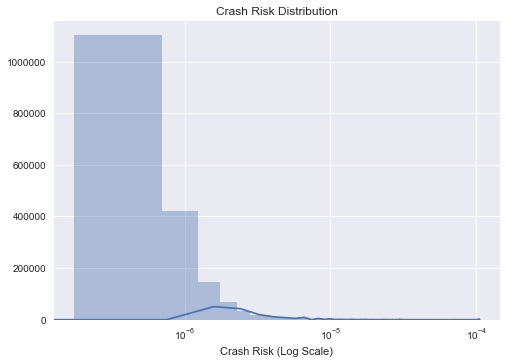

In [15]:
x = street_crashf/(street_traffic * 4728)
sns.distplot(x, bins = 200)
plt.xscale('log')
plt.title('Crash Risk Distribution')
plt.xlabel('Crash Risk (Log Scale)')

Even with a log x scale the risk factor distribution reveals a right skew, that we have identified as being the result of accidents at very low traffic periods. We will revisit this distribution after we have accounted for severity.

To understand how severe each crash is, let's look at the larger dataset that includes information about fatalties, injuries, and other severity factors.

In [18]:
# Read-in full crash information dataframe
crash = pd.read_csv('crashdata.csv')

C:\Users\Ari\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (79,183) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [19]:
# Extract features related to severity
crash_severity = crash.loc[:,('FATAL', 'FATAL_COUNT', 'FATAL_OR_MAJ_INJ', 'INJURY', 'INJURY_COUNT', 'MAJ_INJ_COUNT', 'MAJOR_INJURY', 'MAX_SEVERITY_LEVEL', 'VEHICLE_COUNT','DEC_LAT','DEC_LONG')]

In [20]:
# Merge severity information with crash location and traffic information
crash_sev_loc = crash_severity.merge(crash_location)

Using the severity data with location data allows us to answer questions like, which road experienced the most fatalities? However, to find the most dangerous road incorporating severity data let's examine additional severity measures.

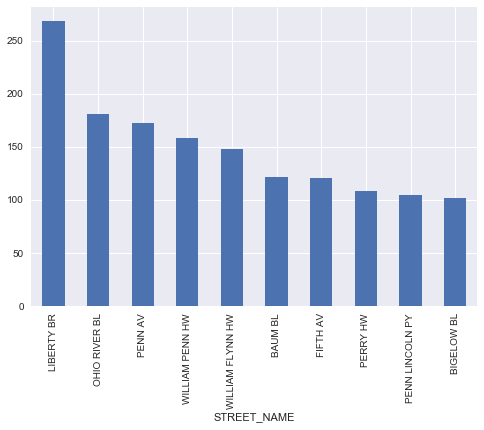

In [21]:
crash_sev_loc.groupby('STREET_NAME').sum().FATAL_COUNT.sort_values(ascending = False).head(10).plot(kind = 'bar')

Severity of a crash captures the injuries, and fatalities of a crash. The issue with only using Injury Count and Fatality Count to construct the severity metric is they are equally weighted (a fatality does not count as an injury in this dataset). The last term, Fatality or Major Injury + 1, is a 1 or 2 and solves the issue of underweighting serious crashes by doubling the severity of such crashes.

1 must be added to each term because the severity will be multiplied by each crash, and a severity of 0 would effectively negate the existence of the crash in the calculation of danger.

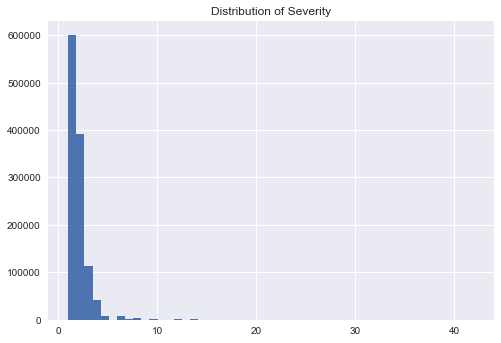

In [22]:
y = (crash_sev_loc.INJURY_COUNT + 1) * (crash_sev_loc.FATAL_COUNT + 1) * (crash_sev_loc.FATAL_OR_MAJ_INJ + 1)
crash_sev_loc['severity'] = y
y.hist(bins = 50)
plt.title('Distribution of Severity')

There are some limitations of this severity metric. Primarily, it is not easily interpretable like the crash risk metric. The other limitation is the severity metric does not distinguish between crashes of different injury levels, minor and moderate injury will result in same risk score.

Noting these limitations, we can now revisit the most dangerous roads. Crash danger is defined as the sum of crash risk * severity for all crashes on a road segment.

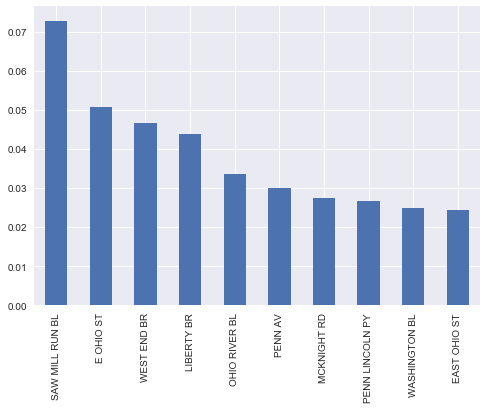

In [23]:
major_roads = crash_sev_loc[(crash_sev_loc.max_traffic >= 50) & (crash_sev_loc.STREET_NAME.duplicated() == True)]

major_traffic = crash_sev_loc.groupby('STREET_NAME').sum().traffic
major_crashf = crash_sev_loc.STREET_NAME.value_counts().sort_index()
major_sev = crash_sev_loc.groupby('STREET_NAME').sum().severity

((major_crashf * major_sev) / (major_traffic * 4728)).sort_values(ascending = False).head(10).plot(kind = 'bar')
# Need to correct E Ohio St replicated in dataset

Factoring in danger, the rankings shift yet again to highways and large thoroughfares. Highways are associated with high speed limits which could be associated with higher severity crashes.

Now that we have defined crash danger we can investigate the relationships with speed limit, intersection type, road conditions, and more.

Part 2 of the Data Story will investigate and reveal the conditions that impact road danger.

In [26]:
crash_sev_loc.to_pickle('crash_sev_loc.pkl')